## Breif Look at the Dataset

In [1]:
import pandas as pd
titanic_data = pd.read_csv("train.csv")

In [2]:
titanic_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Butler, Mr. Reginald Fenton",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


* Note: We can see right away that the data set contains 891 passangers; however, only **714** of these passangers have their age logged, **204** have their cabin number logged, and **889** have where they embarked on.

* Possible **COA** (Course of Action):
  - Categorical:
    - **(Sex)** SimpleImputer using ** *most_frequent* ** to catch all missing sex features in the test set, and use OrdinalEncoder to transform the sex from strings to 1's and 0's
    - **(Cabin)** Drop Cabin feature since less than 25% of the data has the cabin column logged.
    - **(Embarked)** SimpleImputer using ** *most_frequent* ** to catch all missing embarked feature in the test set, and user OneHotEncoder to transform "C", "S", and "Q" to three seperate features
    - **(Ticket)** Use SimpleImputer and OrdinalEncoder
    - **(Name)** Split into two features (Title : Last Name) , then use SimpleImputer and OrdinalEncoder
  - Numerical:
    - **(PassengerId, Pclass, Age, SibSp, Parch, Fare)** SimpleImputer using ** *mean* **

## Create Pipeline

In [676]:
from sklearn.preprocessing import OrdinalEncoder
class NameSplitter(BaseEstimator,TransformerMixin):
    def __init__(self):
        self._ordinal_encoder = OrdinalEncoder()
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        last_name_np = np.empty(shape=(len(X)), dtype=object)
        title_np = np.empty(shape=(len(X)), dtype=object)

        x_copy = np.array(X).flatten()

        for i in range(len(X)):
            last_name_np[i], rest_of_name = x_copy[i].split(',')
            title_np[i] = rest_of_name.split('.')[0]

        ## LastName, Title
        last_and_title = np.c_[last_name_np, title_np]
        last_and_title_ord = self._ordinal_encoder.fit_transform(last_and_title)
        
        return last_and_title_ord

In [677]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

embarked_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent", missing_values=np.nan)), ## gets most frequently used value and replaces nan's with that value
    ('one_hot', OneHotEncoder()), ## one hot encodes this feature
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent", missing_values=np.nan)), ## gets most frequently used value and replaces nan's with that value
    ('ordinal_encoder', OrdinalEncoder()), ## Replaces each string with an integer [0,n_categories-1]
])


In [678]:
from sklearn.compose import ColumnTransformer

num_list = ['PassengerId','Pclass','Age','SibSp','Parch','Fare']
preproccesor = ColumnTransformer([
    ("numerical", SimpleImputer(strategy="most_frequent", missing_values=np.nan), num_list ),
    ("embarked", embarked_pipeline, ['Embarked'] ),
    ("name",NameSplitter(),['Name']),
    ("cat", cat_pipeline, ['Sex','Ticket','Survived']),
])
## Missing: 'Name','Cabin'
preprocessed_titanic_data = preproccesor.fit_transform(titanic_data)

In [679]:
preprocessed_titanic_data[0]

array([  1.  ,   3.  ,  22.  ,   1.  ,   0.  ,   7.25,   0.  ,   0.  ,
         1.  ,  73.  ,  11.  ,   1.  , 630.  ,   0.  ])

In [680]:
preproccesor.transformers_[1][1][1].categories_[0]

array(['C', 'Q', 'S'], dtype=object)

In [681]:
num_list

['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [682]:
columns = num_list + preproccesor.transformers_[1][1][1].categories_[0].tolist() + ['LastName'] + ['Title'] + ['Sex'] + ['Ticket'] + ['Survived']

In [683]:
columns

['PassengerId',
 'Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'C',
 'Q',
 'S',
 'LastName',
 'Title',
 'Sex',
 'Ticket',
 'Survived']

In [684]:
preprocessed_titanic_data_df = pd.DataFrame(preprocessed_titanic_data,columns=columns)

In [685]:
preprocessed_titanic_data_df.describe(include="all")

,PassengerId,Pclass,Age,SibSp,Parch,Fare,C,Q,S,LastName,Title,Sex,Ticket,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,28.566970,0.523008,0.381594,32.204208,0.188552,0.086420,0.725028,326.023569,10.241302,0.647587,324.806958,0.383838
std,257.353842,0.836071,13.199572,1.102743,0.806057,49.693429,0.391372,0.281141,0.446751,193.555742,1.830798,0.477990,197.701497,0.486592
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,22.000000,0.000000,0.000000,7.910400,0.000000,0.000000,0.000000,161.500000,8.000000,0.000000,149.000000,0.000000
50%,446.000000,3.000000,24.000000,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,317.000000,11.000000,1.000000,315.000000,0.000000
75%,668.500000,3.000000,35.000000,1.000000,0.000000,31.000000,0.000000,0.000000,1.000000,494.500000,11.000000,1.000000,496.500000,1.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000,1.000000,1.000000,666.000000,16.000000,1.000000,678.000000,1.000000


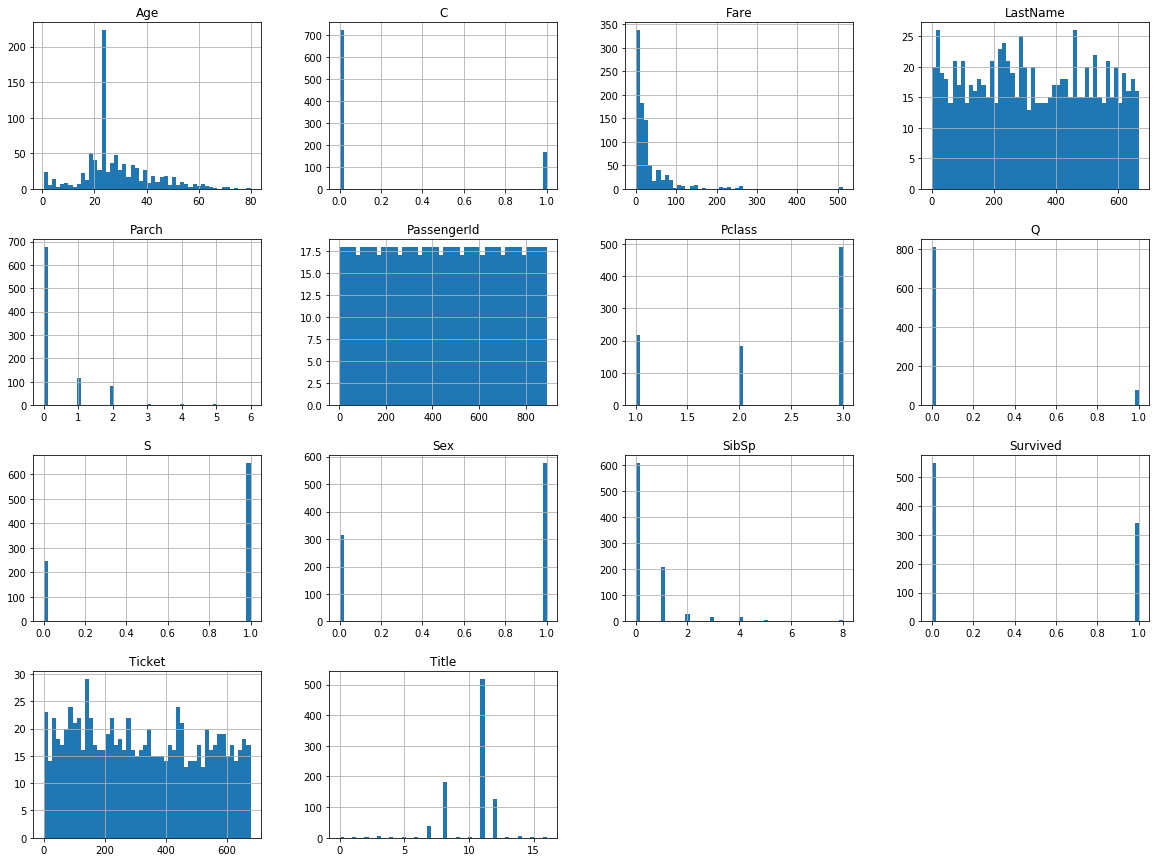

In [686]:
import matplotlib.pyplot as plt
preprocessed_titanic_data_df.hist(bins=50,figsize=(20,15))
plt.show()

* Note: The ranges for these features vary pretty heavily (Age : [0,80] , PassengerId : [0,800]). We can obviously benefit from some form of **feature scaling**.

## Discover Correlations

In [687]:
corr_matrix = preprocessed_titanic_data_df.corr()

In [688]:
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
C              0.168240
Parch          0.081629
Q              0.003650
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.052872
LastName      -0.058100
S             -0.149683
Title         -0.193635
Ticket        -0.286645
Pclass        -0.338481
Sex           -0.543351
Name: Survived, dtype: float64